<a href="https://colab.research.google.com/github/KazutoYamada/Data_Augmentation_for_Seq2Seq/blob/main/Data_Augmentation_for_Seq2Seq(ja).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
Suggested packages:
  apt-xapian-index aptitude-doc-en | aptitude-doc debtags tasksel
  libcwidget-dev xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcwidget4 libsigc++-2.0-0v5 libxapian30
0 upgraded, 5 newly installed, 0 to remove and 15 not upgraded.
Need to get 3,838 kB of archives.
After this operation, 17.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 aptitude-common all 0.8.13-3ubuntu1 [1,719 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsigc++-2.0-0v5 amd64 2.10.4-2ubuntu3 [12.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libcwidget4 amd64 0.5.18-5build1 [306 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libxapian30 amd64

In [ ]:
!pip install torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import MeCab

tagger = MeCab.Tagger('-Owakati')
def tokenizer(text):
    return tagger.parse(text).split()

In [ ]:
import glob  # ファイルの取得に使用
import json  # jsonファイルの読み込みに使用
import re

path = "/content/drive/My Drive/BrushJapanease/texts"  # フォルダの場所を指定

files = glob.glob(path + "/*.txt")  # ファイルの一覧
dialogues = []  # 複数の対話文を格納するリスト
text_num= 1
for file in files:
    with open(file, mode = "r", encoding = 'utf-8') as f:
        contexts = f.read()
    contexts = contexts.split('\n')
    if len(contexts) < 3:
        print(file+':テキスト不備1')
        text_num += 1
        continue
    if len(tokenizer(contexts[0]))==len(tokenizer(contexts[1])):
        dialogues.append(contexts)
    else:
        print(file+':テキスト不備2')
        text_num += 1
        continue
    text_num += 1

print("get", len(dialogues), "context pairs in files", len(files))

get 100 context pairs in files 100


In [ ]:
from collections import Counter
import torch
from torchtext.vocab import vocab
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

In [ ]:
max = 0
for dialogue in dialogues:
    for text in dialogue:
        count = len(tokenizer(text))
        if max < count:
            max = count
print('max_sequence', max)

max_sequence 104


In [ ]:

from sklearn.model_selection import train_test_split

dialogues_train, dialogues_test =  train_test_split(dialogues, shuffle=True, test_size=0.2)


In [ ]:
input_texts1 = [row[0] for row in dialogues]
input_texts2 = [row[1] for row in dialogues]
input_texts = input_texts1 + input_texts2
reply_texts = [row[2] for row in dialogues]

In [ ]:
input_counter = Counter()
reply_counter = Counter()

for text in input_texts:
    text_w = tokenizer(text)
    input_counter.update(text_w)

for text in reply_texts:
    text_w = tokenizer(text)
    reply_counter.update(text_w)

input_vocabulary = vocab(input_counter,
                   #min_freq=3,
                   specials=('<unk>', '<sos>', '<eos>','<pad>'))
reply_vocabulary = vocab(reply_counter,
                   #min_freq=3,
                   specials=('<unk>', '<sos>', '<eos>','<pad>'))

input_vocabulary.set_default_index(input_vocabulary['<unk>'])
reply_vocabulary.set_default_index(reply_vocabulary['<unk>'])

#print(input_vocabulary.get_stoi())
print(input_vocabulary.get_itos()[:10])
#print(reply_vocabulary.get_stoi())
print(reply_vocabulary.get_itos()[:10])
print(len(input_vocabulary))

['<unk>', '<sos>', '<eos>', '<pad>', '稀', 'に', '4', 'クォーク', 'の', '粒子']
['<unk>', '<sos>', '<eos>', '<pad>', 'まれ', 'に', '4', '個', 'の', 'テトラクォーク']
1183


[6, 7, 8, 9, 10]


In [ ]:
import random

def text_transform(_text, max_length=110, switch_rate = 1.0):
    inputs1_index = [input_vocabulary[token] for token in tokenizer(_text[0])][:max_length]
    inputs2_index = [input_vocabulary[token] for token in tokenizer(_text[1])][:max_length]
    num = random.random()
    for i in range(len(inputs1_index)):
        if random.random() < switch_rate:
            inputs1_index[i] = inputs2_index[i]

    replys_index = [reply_vocabulary[token] for token in tokenizer(_text[2])][:max_length-2]
    replys_index = [reply_vocabulary['<sos>']] + replys_index + [reply_vocabulary['<eos>']]
    return inputs1_index, replys_index

def collate_batch(batch):
   inputs_text_list, replys_text_list = [], []

   for _text in batch:

      processed_inputs_text, processed_replys_text = text_transform(_text)

      inputs_text_list.append(torch.tensor(processed_inputs_text))
      replys_text_list.append(torch.tensor(processed_replys_text))

   return pad_sequence(inputs_text_list, padding_value=input_vocabulary['<pad>']).T, pad_sequence(replys_text_list, padding_value=reply_vocabulary['<pad>']).T

In [ ]:
batch_size = 10

train_dataloader = DataLoader(
   dialogues_train,
   batch_size=batch_size,
   shuffle=True,
   collate_fn=collate_batch
)
test_dataloader = DataLoader(
   dialogues_test,
   batch_size=batch_size,
   shuffle=False,
   collate_fn=collate_batch
)

In [ ]:
inp_text, rep_text = next(iter(train_dataloader))  # ミニバッチを取り出す
print(inp_text.size())  # ミニバッチにおける入力のサイズ
print(inp_text[0])  # 最初の要素
print(rep_text.size())  # ミニバッチにおける応答のサイズ
print(rep_text[0])  # 最初の要素

torch.Size([10, 47])
tensor([1153,    8,  211,  212,   44,  213,  104,   26,  193,  190,    8,  205,
          44,  222,   51, 1146,   21,   26,  223,  127,    5,   21,  176,  177,
         178,    8,  189,  190,    8,  187,  224,    8,  191,    5, 1154,  207,
         172,   42,   17,   29,   66,   18,    3,    3,    3,    3,    3])
torch.Size([10, 60])
tensor([  1, 213,   8, 204, 205,  15, 206, 101,  24, 188, 185,   8, 196,  15,
        218,  17, 216,  19,  24, 219,  59,   5,  19, 170, 171, 172,   8, 182,
        220,   8, 186,   5, 221,  27,  65,  18,   2,   3,   3,   3,   3,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
          3,   3,   3,   3])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, n_h, n_vocab, n_emb, num_layers=1, bidirectional=False, dropout=0.0):
        super().__init__()

        self.n_h = n_h
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.dropout = dropout  # ドロップアウト層

        # 埋め込み層
        self.embedding = nn.Embedding(n_vocab, n_emb)
        self.embedding_dropout = nn.Dropout(self.dropout)

        self.gru = nn.GRU(  # GRU層
            input_size=n_emb,  # 入力サイズ
            hidden_size=n_h,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
            num_layers=num_layers,  # RNN層の数（層を重ねることも可能）
            bidirectional=bidirectional,  # Bidrectional RNN
        )

    def forward(self, x):
        # 文章の長さを取得
        idx_pad = input_vocabulary["<pad>"]
        sentence_lengths = x.size()[1] - (x == idx_pad).sum(dim=1)
        sentence_lengths = sentence_lengths.cpu()
        y = self.embedding(x)  # 単語をベクトルに変換
        y = self.embedding_dropout(y)
        y = nn.utils.rnn.pack_padded_sequence(  # 入力のパッキング
            y,
            sentence_lengths,
            batch_first=True,
            enforce_sorted=False
            )
        y, h = self.gru(y)

        y, _ = nn.utils.rnn.pad_packed_sequence(y, batch_first=True)  # テンソルに戻す
        if self.bidirectional:  # 双方向の値を足し合わせる
            y = y[:, :, :self.n_h] + y[:, :, self.n_h:]
            h = h[:self.num_layers] + h[self.num_layers:]
        return y, h

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_h, n_out, n_vocab, n_emb, num_layers=1, dropout=0.0):
        super().__init__()

        self.n_h = n_h
        self.n_out = n_out
        self.num_layers = num_layers
        self.dropout = dropout

        # 埋め込み層
        self.embedding = nn.Embedding(n_vocab, n_emb)
        self.embedding_dropout = nn.Dropout(self.dropout)  # ドロップアウト層

        self.gru = nn.GRU(  # GRU層
            input_size=n_emb,  # 入力サイズ
            hidden_size=n_h,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
            num_layers=num_layers,  # RNN層の数（層を重ねることも可能）
        )

        self.fc = nn.Linear(n_h*2, self.n_out)  # コンテキストベクトルが合流するので2倍のサイズ

    def forward(self, x, h_encoder, y_encoder):
        y = self.embedding(x)  # 単語をベクトルに変換
        y = self.embedding_dropout(y)
        y, h = self.gru(y, h_encoder)

        # ----- Attention -----
        y_tr = torch.transpose(y, 1, 2)  # 次元1と次元2を入れ替える
        ed_mat = torch.bmm(y_encoder, y_tr)  # バッチごとに行列積
        attn_weight = F.softmax(ed_mat, dim=1)  # attention weightの計算
        attn_weight_tr = torch.transpose(attn_weight, 1, 2)  # 次元1と次元2を入れ替える
        context = torch.bmm(attn_weight_tr, y_encoder)  # コンテキストベクトルの計算
        y = torch.cat([y, context], dim=2)  # 出力とコンテキストベクトルの合流

        y = self.fc(y)
        y = F.softmax(y, dim=2)

        return y, h

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, is_gpu=True):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.is_gpu = is_gpu
        if self.is_gpu:
            self.encoder.cuda()
            self.decoder.cuda()

    def forward(self, x_encoder, x_decoder):  # 訓練に使用
        if self.is_gpu:
            x_encoder, x_decoder = x_encoder.cuda(), x_decoder.cuda()

        batch_size = x_decoder.shape[0]
        n_time = x_decoder.shape[1]
        y_encoder, h = self.encoder(x_encoder)

        y_decoder = torch.zeros(batch_size, n_time, self.decoder.n_out)
        if self.is_gpu:
            y_decoder = y_decoder.cuda()

        for t in range(0, n_time):
            x = x_decoder[:, t:t+1]  # Decoderの入力を使用
            y, h= self.decoder(x, h, y_encoder)
            y_decoder[:, t:t+1, :] = y
        return y_decoder

    def predict(self, x_encoder):  # 予測に使用
        if self.is_gpu:
            x_encoder = x_encoder.cuda()

        batch_size = x_encoder.shape[0]
        n_time = x_encoder.shape[1]
        y_encoder, h = self.encoder(x_encoder)

        y_decoder = torch.zeros(batch_size, n_time, dtype=torch.long)
        if self.is_gpu:
            y_decoder = y_decoder.cuda()

        y = torch.ones(batch_size, 1, dtype=torch.long) * input_vocabulary["<sos>"]
        for t in range(0, n_time):
            x = y  # 前の時刻の出力を入力に
            if self.is_gpu:
                x = x.cuda()
            y, h= self.decoder(x, h, y_encoder)
            y = y.argmax(2)
            y_decoder[:, t:t+1] = y
        return y_decoder

In [ ]:
def evaluate_model(model, iterator):
    model.eval()  # 評価モード

    (inp_text, _) = next(iter(iterator))
    x = inp_text
    y = model.predict(x)
    for i in range(x.size()[0]):
        inp_text = ""
        for j in range(x.size()[1]):
            word = input_vocabulary.get_itos()[x[i][j]]
            if word=="<pad>":
                break
            inp_text += word

        rep_text = ""
        for j in range(y.size()[1]):
            word = reply_vocabulary.get_itos()[y[i][j]]
            if word=="<eos>":
                break
            rep_text += word

        print("input:", inp_text)
        print("reply:", rep_text)
        print()

In [ ]:
from torch import optim

is_gpu = True  # GPUを使用するかどうか
n_h = 700
n_vocab_inp = len(input_vocabulary)
n_vocab_rep = len(reply_vocabulary)
n_emb = 300
n_out = n_vocab_rep
early_stop_patience = 10  # 早期終了のタイミング（誤差の最小値が何回更新されなかったら終了か）
num_layers = 1
bidirectional = True
dropout = 0
clip = 10

# Seq2Seqのモデルを構築
encoder = Encoder(n_h, n_vocab_inp, n_emb, num_layers, bidirectional, dropout=dropout)
decoder = Decoder(n_h, n_out, n_vocab_rep, n_emb, num_layers, dropout=dropout)
seq2seq = Seq2Seq(encoder, decoder, is_gpu=is_gpu)

# 誤差関数
loss_fnc = nn.CrossEntropyLoss(ignore_index=reply_vocabulary["<pad>"])

# 最適化アルゴリズム
optimizer_enc = optim.Adam(seq2seq.parameters(), lr=0.0001)
optimizer_dec = optim.Adam(seq2seq.parameters(), lr=0.0005)

# 損失のログ
record_loss_train = []
record_loss_test = []
min_losss_test = 0.0

# 学習
for i in range(100):
    # 訓練モード
    seq2seq.train()

    loss_train = 0
    for j, (inp, rep) in enumerate(train_dataloader):
        x_enc = inp
        x_dec = rep[:, :-1]
        y_dec = seq2seq(x_enc, x_dec)

        t_dec = rep[:, 1:]
        t_dec = t_dec.cuda() if is_gpu else t_dec
        loss = loss_fnc(
            y_dec.view(-1, y_dec.size()[2]),
            t_dec.contiguous().view(-1)
            )
        loss_train += loss.item()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(encoder.parameters(), clip)
        nn.utils.clip_grad_norm_(decoder.parameters(), clip)
        optimizer_enc.step()
        optimizer_dec.step()

        if j%1000==0:
            print("batch:", str(j)+"/"+str(len(dialogues_train)//batch_size+1), "loss:", loss.item())
    loss_train /= j+1
    record_loss_train.append(loss_train)

    # 評価モード
    seq2seq.eval()

    loss_test = 0
    for j, (inp, rep) in enumerate(test_dataloader):
        x_enc = inp
        x_dec = torch.ones(rep.size(), dtype=torch.long) * reply_vocabulary["<sos>"]
        x_dec[:, 1:] = rep[:, :-1]
        y_dec = seq2seq(x_enc, x_dec)

        t_dec = rep.cuda() if is_gpu else rep
        loss = loss_fnc(
            y_dec.view(-1, y_dec.size()[2]),
            t_dec.contiguous().view(-1)
            )
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)
        print()

    evaluate_model(seq2seq, test_dataloader)

    # ----- 早期終了 -----
    latest_min = min(record_loss_test[-(early_stop_patience):])  # 直近の最小値
    if len(record_loss_test) >= early_stop_patience:
        if latest_min > min_loss_test:  # 直近で最小値が更新されていなければ
            print("Early stopping!")
            break
        min_loss_test = latest_min
    else:
        min_loss_test = latest_min

batch: 0/9 loss: 6.965073585510254
Epoch: 0 Loss_Train: 6.956674337387085 Loss_Test: 6.917540788650513

input: 主要な戦略は、主な温室効果ガスであるCO2の排出を回収し、ガスを地下に貯蔵したり、CO2を利用可能な製品に変えたりすることだ。
reply: 

input: アニマルフリー食品関連技術は2010年代後半からのびている傾向がある事がわかる。
reply: 研究、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、

input: 原子レベルで分散した白金、鉄単体、白金-鉄合金のナノ粒子からなり、従来の触媒のような単一部位ではなく、OPRの反応経路に必要な３種類の活性部位を形成していることを理論シミュレーションより確認している。
reply: 

input: ポリプロピレンやポリエチレンなどのリサイクルがむずかしいプラスチックに水素を添加する反応（水素化分解）は、プラスチック廃棄物を付加価値の高い低級炭化水素に変換する有望な方法であることは良く知られている。
reply: 

input: 米国MITの研究チームは、再生可能エネルギ―プロセスにおいて不可欠な技術である、燃料電池或いは、この逆反応のデバイスである電解セルにおいて、これらの寿命を飛躍的に伸ばす比較的簡単で極めて有効な方法、すなわちシステムのpHを変更することを発見した。
reply: 、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、

input: この研究は、2023年6月２日付で『NatureCatalysis』誌に掲載されている。
reply: 、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、

input: タービンは、効率が90%を超え、第三者機関のテストによると、99%以上の魚が安全に通過できる厚いブレードを供えている。
reply: 、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、、

KeyboardInterrupt: ignored

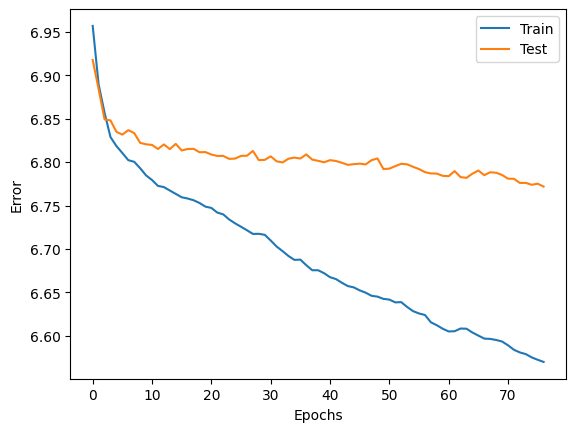

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()